In [64]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [3]:
# Load files 
run_info = pd.read_csv("./run_info.csv") # stores config information of each run
print(run_info.columns) 
cross_validation = pd.read_csv("./cross_validation.csv", header=None) # ERM evaluations, (i,j) entry is accuracy evaluated on domain j after training on 1000 samples from doamin i
cross_validation = cross_validation.values
print(cross_validation)

Index(['run', 'domains', 'method', 'id'], dtype='object')
[[0.6494  0.1652  0.3111  0.09699 0.4735  0.287  ]
 [0.3247  0.4174  0.3926  0.05351 0.4875  0.2963 ]
 [0.3247  0.2435  0.763   0.0903  0.6072  0.3889 ]
 [0.1299  0.04348 0.05926 0.7458  0.1142  0.1019 ]
 [0.4156  0.1478  0.437   0.08027 0.8384  0.3796 ]
 [0.4286  0.09565 0.2444  0.1739  0.4652  0.6574 ]]


In [51]:
def exponential_smoothing(series, alpha):
    # print(f"Using exponential smoothing, smoothing factor is {alpha}")
    smoothed = [series[0]]
    for i in range(1, len(series)):
        smoothed_val = alpha * series[i] + (1 - alpha) * smoothed[i-1]
        smoothed.append(smoothed_val)
    return np.array(smoothed)

# take mean(rounds i to i + smoothing_factor - 1) as value for round i
def running_average_smoothing(series, smoothing_factor):
    # print(f"Using running average smoothing, smoothing factor is {smoothing_factor}")
    smoothed = [np.mean(series[i: i+smoothing_factor]) for i in range(len(series)-smoothing_factor + 1)]
    return smoothed

def get_smoothing_function(method, smoothing_factor):
    if method == 'exponential':
        function = exponential_smoothing
    elif method == 'running_average':
        function = running_average_smoothing
    def smoothing(series):
            return function(series, smoothing_factor)
    return smoothing

    

In [97]:
def calculate_efficiencies(run_names, al_performance, smoothing_function, threshold_round):
    num_runs = len(run_names)
    al_perf_dict = {}
    runs = []
    effs = []
    for i in range(num_runs): 
        run_name = run_names[i]
        info = run_info.loc[run_info['run']==run_name]
        # print(info)
        if info['method'].values[0] == 'margin':
            margin_perf = al_performance.loc[:, run_name].values
            random_dual_info = run_info.loc[(run_info['domains'] == info['domains'].values[0]) & (run_info['method'] == 'random')]
            # print(random_dual_info)
            random_name = random_dual_info['run'].values[0]
            random_perf = al_performance.loc[:, random_name].values

            smoothed_margin_perf = smoothing_function(margin_perf)
            smoothed_random_perf = smoothing_function(random_perf)
            threshold_acc = smoothed_margin_perf[threshold_round]
            first_matching_index = np.sort(np.nonzero(smoothed_random_perf > threshold_acc)[0])[0]
            efficiency = first_matching_index / threshold_round
            # print(f"matching index is {first_matching_index}")
            # print(f"data efficiency is {efficiency}")
            al_perf_dict[run_name] = efficiency
            runs.append(run_name)
            effs.append(efficiency)
    return runs, effs

In [98]:
# Calculate data efficiencies of active learning under different domain compositions
threshold_round = 60 # the query at which we select margin's val acc and use that to find data efficiency compared with random
smoothing_method = 'running_average'
smoothing_factor = 5
# smoothing_method = 'exponential'
# smoothing_factor = 0.9
smoothing_function = get_smoothing_function(smoothing_method, smoothing_factor)

al_performance = pd.read_csv("./al_performance.csv")
run_names = list(al_performance.columns)[1:]

runs, effs = calculate_efficiencies(run_names, al_performance, smoothing_function, threshold_round)
print(f"Number of datapoints: {len(runs)}")

Number of datapoints: 14


In [10]:
# Calculate prediction metrics
num_domain = 6
# DOMAIN_NET_DOMAINS = ["clipart", "infograph", "painting", "quickdraw", "real", "sketch"]
natural_counts = np.array([3672, 5069, 6553, 14000, 15985, 5466])

In [11]:
# Load selection frequency files and calculate margin's selection weight
n = 3 # use the average selection freq of the first n query rounds as heuristics for al selection weight
freq = pd.read_csv(f"./selection_frequency/0.csv")
columns = list(freq.columns)
selection_freq = pd.DataFrame(data = np.zeros((num_domain, len(columns))), columns=columns)
for i in range(num_domain):
    domain = i 
    file = f"./selection_frequency/{domain}.csv"
    freq = pd.read_csv(file)
    # print(freq.shape)
    first_n_rounds = freq.iloc[:n, :].to_numpy()
    average = np.mean(first_n_rounds, axis = 0)
    selection_freq.iloc[i, :] = average
print(f"Calculated selection_freq is of shape {selection_freq.shape}")

Calculated selection_freq is of shape (6, 14)


In [153]:
# metric1 = sum_i natural_weight(i) sum_j selection_weight(j) acc(j->i)
# metric2 = sum_i natural_weight(i) sum_j selection_weight(j) acc(j->i)/acc(i->i)
# metric3 = metric1(natural, natural) / metric1(natural, select)
# metric4 = metric2(natural, natural) / metric2(natural, select)

def metric1(cross_validation, selection_weight, natural_weight):
    metric = np.sum(np.sum(cross_validation * selection_weight.reshape((-1, 1)), axis = 0) * natural_weight)
    return metric

def metric2(cross_validation, selection_weight, natural_weight):
    diagonal = np.reshape(np.diagonal(cross_validation), (1, -1))
    metric = np.sum(np.sum(cross_validation / diagonal * selection_weight.reshape((-1, 1)), axis = 0) * natural_weight)
    return metric

def metric3(cross_validation, selection_weight, natural_weight):
    metric_margin = metric1(cross_validation, selection_weight, natural_weight)
    metric_random = metric1(cross_validation, natural_weight, natural_weight)
    metric = metric_random / metric_margin
    return metric

def metric4(cross_validation, selection_weight, natural_weight):
    metric_margin = metric2(cross_validation, selection_weight, natural_weight)
    metric_random = metric2(cross_validation, natural_weight, natural_weight)
    return metric_random / metric_margin

# def metric3(cross_validation, selection_weight, natural_weight):
#     return metric1(cross_validation, natural_weight, natural_weight)

# def metric4(cross_validation, selection_weight, natural_weight):
#     return metric2(cross_validation, natural_weight, natural_weight)


# def metric3r(cross_validation, selection_weight, natural_weight):
#     new_cross_validation = np.array(cross_validation)
#     for i in range(new_cross_validation.shape[0]):
#         new_cross_validation[i, i] = 0
#     metric = np.sum(np.sum(new_cross_validation * selection_weight.reshape((-1, 1)), axis = 0) * natural_weight)
#     return metric

# def metric4r(cross_validation, selection_weight, natural_weight):
#     diagonal = np.reshape(np.diagonal(cross_validation), (1, -1))
#     new_cross_validation = np.array(cross_validation)
#     for i in range(new_cross_validation.shape[0]):
#         new_cross_validation[i, i] = 0
#     metric = np.sum(np.sum(new_cross_validation / diagonal * selection_weight.reshape((-1, 1)), axis = 0) * natural_weight)
#     return metric


metric_functions = {"metric1": metric1, "metric2": metric2, "metric3": metric3, "metric4": metric4}

In [154]:
# For each datapoint (domain composition), calculate prediction metrics
metrics_used = ['metric1', 'metric2', 'metric3', 'metric4'] 
metrics_result = {metric_name: [] for metric_name in metrics_used}

for run in runs:
    # print(run)
    domain_str = str(run_info.loc[run_info['run'] == run, 'domains'].values[0])
    # print(domain_str)
    domains = [int(g) - 1 for g in domain_str]
    # print(domains)
    mask = np.zeros(num_domain)
    mask[domains] = 1
    natural_weight = mask * natural_counts 
    natural_weight = natural_weight / np.sum(natural_weight)
    # print(natural_weight)
    selection_weight = selection_freq.loc[:,run].values / 100
    # print(selection_weight)

    for metric_name in metrics_used:
        metrics_result[metric_name].append(metric_functions[metric_name](cross_validation, selection_weight, natural_weight))
    

In [101]:
def log_graph_metric(effs, metrics, name = "Metric", print_info=False):
    r = np.corrcoef(effs, metrics)[0,1]
    rho, p_value = spearmanr(effs, metrics)
    
    if print_info:
        plt.scatter(effs, metrics, label="al performance prediction")
        plt.title(f"{name}")
        plt.xlabel("active learning data efficiency")
        plt.ylabel("predicted metric")
        plt.show()
        print("Spearman correlation coefficient:", r)
        print("Spearman rank correlation coefficient:", rho)
        print("p-value:", p_value)

    return r, rho

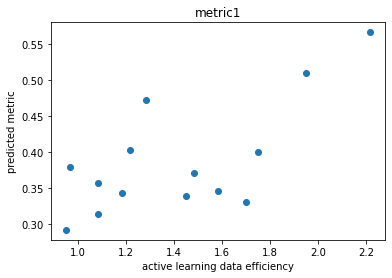

Spearman correlation coefficient: 0.6810630494804011
Spearman rank correlation coefficient: 0.5280531248166693
p-value: 0.05226547102199243


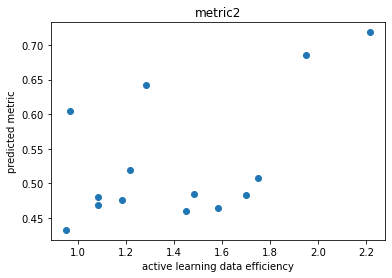

Spearman correlation coefficient: 0.5345157734536925
Spearman rank correlation coefficient: 0.4730475909815996
p-value: 0.08757002771574113


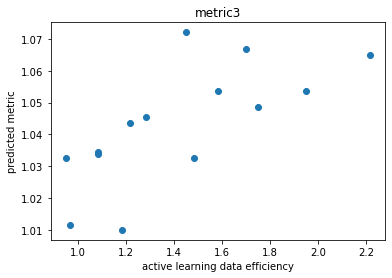

Spearman correlation coefficient: 0.7048363004457096
Spearman rank correlation coefficient: 0.7172721612093091
p-value: 0.0038814319254785942


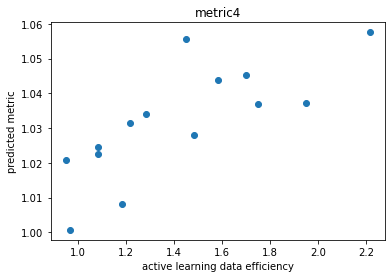

Spearman correlation coefficient: 0.7613163797940034
Spearman rank correlation coefficient: 0.8404845569998652
p-value: 0.00016712211804068407


In [155]:
metrics_list = ['metric1', 'metric2', 'metric3', 'metric4']
for metric in metrics_list:
    r, rho = log_graph_metric(effs, metrics_result[metric], name=metric, print_info=True)

In [105]:

def corr_to_round(metrics, threshold_rounds, print_each = False):
    r_list = []
    rho_list = []
    for threshold_round in threshold_rounds:
        _, effs = calculate_efficiencies(run_names, al_performance, smoothing_function, threshold_round)
        r, rho = log_graph_metric(effs, metrics, print_info=print_each)
        r_list.append(r)
        rho_list.append(rho)
    return r_list, rho_list

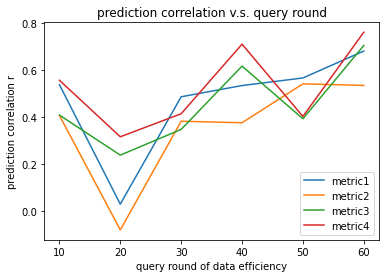

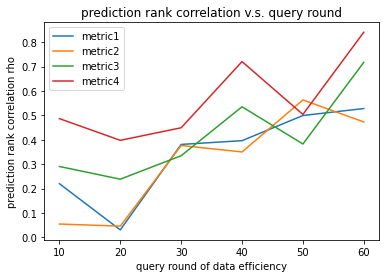

In [133]:
threshold_rounds = list(range(10,70,10))
metrics_list = ['metric1', 'metric2', 'metric3', 'metric4']
metric_r_list = []
metric_rho_list = []
for metric in metrics_list:
    metrics = metrics_result[metric]
    r_list, rho_list = corr_to_round(metrics, threshold_rounds, print_each=False)
    metric_r_list.append(r_list)
    metric_rho_list.append(rho_list)

for i in range(len(metrics_list)):
    plt.plot(threshold_rounds, metric_r_list[i], label=f"{metrics_list[i]}")
plt.title("prediction correlation v.s. query round")
plt.xlabel("query round of data efficiency")
plt.ylabel("prediction correlation r")
plt.legend()
plt.show()

for i in range(len(metrics_list)):
    plt.plot(threshold_rounds, metric_rho_list[i], label=f"{metrics_list[i]}")
plt.title("prediction rank correlation v.s. query round")
plt.xlabel("query round of data efficiency")
plt.ylabel("prediction rank correlation rho")
plt.legend()
plt.show()

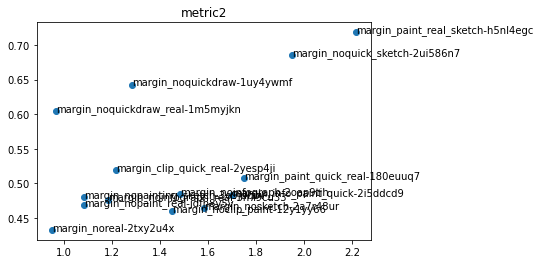

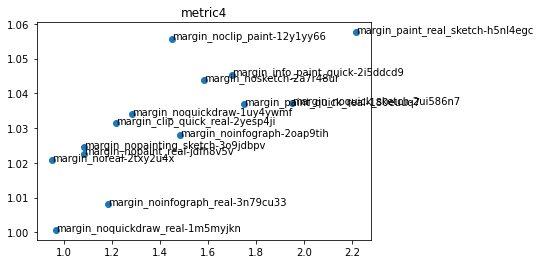

In [136]:
metrics_list = ['metric2', 'metric4']
for metric in metrics_list:
    x = effs
    y = metrics_result[metric]
    labels = runs

    fig, ax = plt.subplots()
    plt.title(metric)

    ax.scatter(x, y)

    for i, label in enumerate(labels):
        ax.annotate(label, (x[i], y[i]))

    plt.show()

In [31]:
print(runs)
print(effs)
print(metrics2)

['margin_nosketch-2a7r48ur', 'margin_noclip_paint-12y1yy66', 'margin_paint_quick_real-180euuq7', 'margin_info_paint_quick-2i5ddcd9', 'margin_noquick_sketch-2ui586n7', 'margin_clip_quick_real-2yesp4ji', 'margin_paint_real_sketch-h5nl4egc', 'margin_nopaint_real-jdfh8v5v', 'margin_noquickdraw_real-1m5myjkn', 'margin_nopainting_sketch-3o9jdbpv', 'margin_noquickdraw-1uy4ywmf', 'margin_noinfograph-2oap9tih', 'margin_noreal-2txy2u4x', 'margin_noinfograph_real-3n79cu33']
[1.5833333333333333, 1.45, 1.75, 1.7, 1.95, 1.2166666666666666, 2.216666666666667, 1.0833333333333333, 0.9666666666666667, 1.0833333333333333, 1.2833333333333334, 1.4833333333333334, 0.95, 1.1833333333333333]
[0.46412873845557867, 0.46005641935736935, 0.507911958943949, 0.48352064666885947, 0.6849621537328241, 0.5196993785965923, 0.7183806325157882, 0.46916083993366087, 0.6039856108839724, 0.48023777749226715, 0.6427247852533826, 0.4845688394323439, 0.43290601159578235, 0.4767624633687627]


In [32]:
runs[8]

'margin_noquickdraw_real-1m5myjkn'

In [ ]:
print(cross_validation)
diagonal = np.reshape(np.diagonal(cross_validation), (1, -1))
print(cross_validation / diagonal)